In [4]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
import math
import scipy as sp
from nltk.corpus import stopwords

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [5]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [6]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [7]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [8]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [9]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [ ]:
def map_keywords_to_segments()

In [10]:
def mini_print(out_cols, out_rows):
    out_line = PrettyTable(out_cols)
    print(" & ".join(out_cols))
    if type(out_rows[0]) == list or type(out_rows[0]) == tuple:
        for row in out_rows:
            out_line.add_row(row)
            print(" & ".join(map(str, row)))
    else:
        out_line.add_row(out_rows)
        print(" & ".join(map(str, out_rows)))
    print(out_line)

In [8]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [9]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [10]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    #print(display_pp.get_html_string())

    

In [11]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+----------------+----------------------------------------------------+
| pair id |  nid  | ES transcript  |                   EN translation                   |
+---------+-------+----------------+----------------------------------------------------+
|  16210  | 14185 |  CUIDADO PERO  |  NO NO IT IS NO SO SERIOUS BUT SHE HAS THAT THAT   |
|         |       |                | WORRY WHO KNOWS MAYBE IS JUST MASS SOMETHING IS A  |
|         |       |                |                  LITTLE BALL THAT                  |
+---------+-------+----------------+----------------------------------------------------+
|  16210  | 14186 | LLAMAROS Y QUE | WELL SHE SAID THAT SHE SHE WAS GOING TO CALL SO I  |
|         |       |                | SHE HAD LEFT PHONE NUMBER BECAUSE SHE WAS SLEEPING |
|         |       |                | IT NOW TWO TIMES THAT HAS CALLED AND SHE 'S ASLEEP |
|         |       |                |                SO SHE CAN 'T ANSWER                |
+---------

## Matches - cross call vs in call

In [12]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)

In [13]:
eval_df['in_uttr'] = eval_df.apply(lambda r: nodes_dict[r.n1].seg == nodes_dict[r.n2].seg, axis=1)

In [14]:
eval_df['x_call'] = eval_df.apply(lambda r: nodes_dict[r.n1].file != nodes_dict[r.n2].file, axis=1)

In [15]:
eval_df['x_uttr'] = eval_df.apply(lambda r: (nodes_dict[r.n1].file == nodes_dict[r.n2].file) and \
                                  (nodes_dict[r.n1].seg != nodes_dict[r.n2].seg), axis=1)

In [16]:
len(eval_df[eval_df.in_uttr]) + len(eval_df[eval_df.x_uttr]) + len(eval_df[eval_df.x_call])

25501

In [17]:
eval_cols = ["\#", "in_uttr", "x_uttr", "x_call"]
eval_row_tot = ["tot."]
eval_row_corr = ["corr."]
for catg in eval_cols[1:]:
    eval_row_tot.append(len(eval_df[eval_df[catg]]))
    eval_row_corr.append(len(eval_df[(eval_df[catg] == True) & (eval_df.es_cnt_sim > 0)]))

eval_row_ratio = ["\% tot."] + ["{0:.0f}\%".format(tot/len(eval_df)*100) for tot in eval_row_tot[1:]]
eval_row_pr = ["\% corr."] + ["{0:.0f}\%".format(corr/tot*100) for corr, tot in \
                             zip(eval_row_corr[1:], eval_row_tot[1:])]
mini_print(eval_cols, [eval_row_tot, eval_row_ratio, eval_row_corr, eval_row_pr])

\# & in_uttr & x_uttr & x_call
tot. & 616 & 4338 & 20547
\% tot. & 2\% & 17\% & 81\%
corr. & 479 & 2299 & 1575
\% corr. & 78\% & 53\% & 8\%
+----------+---------+--------+--------+
|    \#    | in_uttr | x_uttr | x_call |
+----------+---------+--------+--------+
|   tot.   |   616   |  4338  | 20547  |
| \% tot.  |   2\%   |  17\%  |  81\%  |
|  corr.   |   479   |  2299  |  1575  |
| \% corr. |   78\%  |  53\%  |  8\%   |
+----------+---------+--------+--------+


## Pseudotext analysis

In [18]:
train_segment_list_fname, dev_segment_list_fname

(u'../files-train-segments-63-120-10.txt',
 u'../files-dev-segments-63-120-10.txt')

In [19]:
train_fids = []
train_sids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
        train_sids.append(line.strip())
train_fids = set(train_fids)
train_sids = set(train_sids)

In [20]:
dev_fids = []
dev_sids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
        dev_sids.append(line.strip())
dev_fids = set(dev_fids)
dev_sids = set(dev_sids)

In [21]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
clusters_stats['oov'] = []
clusters_stats['cross_seg'] = []
clusters_stats['cross_file'] = []
clusters_stats['same_seg'] = []
clusters_stats['in_vocab'] = []
for sids in clusters_stats['sids']:
    is_in_dev = len(dev_sids & set(sids)) > 0
    is_in_train = len(train_sids & set(sids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)
    clusters_stats['oov'].append(is_in_dev and not is_in_train)
    clusters_stats['in_vocab'].append(is_in_dev and is_in_train)
    cross_seg = False
    cross_file = False
    same_seg = False
    if is_in_dev and is_in_train:
        common_sids = (dev_sids & set(sids)) | (train_sids & set(sids))
        cross_seg = (len(common_sids) > 1)
        cross_file = (len(set([s.split('.')[0] for s in common_sids])) > 1)
        
    if is_in_dev or is_in_train:
        same_seg = (len(set(sids)) == 1)
        
    clusters_stats['cross_seg'].append(cross_seg)
    clusters_stats['cross_file'].append(cross_file)
    clusters_stats['same_seg'].append(same_seg)
        
        

clusters_stats['dev_depth'] = []
clusters_stats['train_depth'] = []
for nlist in clusters_stats['sids']:
    clusters_stats['dev_depth'].append(len([i for i in nlist if i in dev_sids]))
    clusters_stats['train_depth'].append(len([i for i in nlist if i in train_sids]))


In [22]:
num_oov = sum([i for i in clusters_stats['oov']])
print(num_oov)
sum_oov = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['oov'][i]])
total_pwords = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['is_dev'][i]])
print(sum_oov)
print(total_pwords)

546
601
1577


In [23]:
def oov_summary(dev_sids, feats_dict):
    dev_words = []
    train_words = []
    oov_pwords = []
    for did in dev_sids:
        dev_words.extend([w.decode('utf-8') for w in feats_dict[did]])
    for tid in train_sids:
        train_words.extend([w.decode('utf-8') for w in feats_dict[tid]])
    set_train_words = set(train_words)
    oov_words = [cid for cid in dev_words if cid not in set_train_words and cid != "-1"]
    missing_train_words = [cid for cid in train_words if cid == "-1"]
    missing_words = [cid for cid in dev_words if cid == "-1"]
    out_cols = ["trn wrds", "trn vocab", "dev wrds", "dev vocab", "oov", "oov types", \
                "miss trn", "miss dev", "oov + miss"]
    out_rows = [len(train_words), len(set(train_words)), len(dev_words), len(set(dev_words)), \
                len(oov_words), len(set(oov_words)), len(missing_train_words), len(missing_words), \
                len(oov_words) + len(missing_words)]
    mini_print(out_cols, out_rows)
    return Counter(train_words), Counter(dev_words), Counter(oov_words)

In [24]:
train_pwords, dev_pwords, oov_pwords = oov_summary(dev_sids, feats_dict)
train_gold_words, dev_gold_words, oov_gold_words = oov_summary(dev_sids, gold_feats_dict)

trn wrds & trn vocab & dev wrds & dev vocab & oov & oov types & miss trn & miss dev & oov + miss
20921 & 10354 & 2052 & 1421 & 601 & 546 & 4131 & 475 & 1076
+----------+-----------+----------+-----------+-----+-----------+----------+----------+------------+
| trn wrds | trn vocab | dev wrds | dev vocab | oov | oov types | miss trn | miss dev | oov + miss |
+----------+-----------+----------+-----------+-----+-----------+----------+----------+------------+
|  20921   |   10354   |   2052   |    1421   | 601 |    546    |   4131   |   475    |    1076    |
+----------+-----------+----------+-----------+-----+-----------+----------+----------+------------+
trn wrds & trn vocab & dev wrds & dev vocab & oov & oov types & miss trn & miss dev & oov + miss
38042 & 6638 & 4072 & 1702 & 420 & 399 & 0 & 0 & 420
+----------+-----------+----------+-----------+-----+-----------+----------+----------+------------+
| trn wrds | trn vocab | dev wrds | dev vocab | oov | oov types | miss trn | miss dev |

In [25]:
oov_ratio = [420/4072, 719/4129, 601/2052, 892/2029]
for oov in oov_ratio:
    print("{0:.0f}\%".format(oov*100), end=" & ")

10\% & 17\% & 29\% & 44\% & 

In [26]:
mt_gold_pred_dict[5]['001.001']
mt_pseudo_pred_dict[5]['001.001']
feats_dict['001.001']

['7']

In [27]:
len(dev_pwords), len(set(dev_pwords))

(1421, 1421)

In [28]:
k = 1
pred_count = 0
missing_count = 0
for pw in dev_pwords:
    if pw == "-1":
        print("haha", dev_pwords["-1"])
    elif pw not in pseudo_probs_dict:
        missing_count += dev_pwords[pw]
    else:
        pred_count += (len(pseudo_probs_dict[pw].values()[:k])*dev_pwords[pw])
print(pred_count,missing_count)
print(sum([mt_pseudo_eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)]))
print(sum([len(mt_pseudo_pred_dict[k][sid]) for sid in set(dev_sids)]))
print(sum([1 for sid in dev_sids if len(mt_pseudo_pred_dict[k][sid]) > 0]))
print(sum([1 for sid in dev_sids if len(mt_pseudo_pred_dict[k][sid]) == 0]))
print(sum([1 for sid in dev_sids if feats_dict[sid] == ["-1"]]))
print(sum(dev_pwords.values()))
len(dev_sids), len(train_sids)
print(" &".join(["{0:.0f}\%".format(miss/tot * 100) for tot, miss in [(8055,4093), (911,513), \
                                                             (8094,4131), (872,475)]]))

haha 475
975 602
975
975
332
540
475
2052
51\% &56\% &51\% &54\%


In [29]:
train_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in train_pwords if cid != -1])
dev_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in dev_pwords if cid != -1])
oov_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in oov_pwords if cid != -1])

In [30]:
out_cols = ["train/dev/oov", "total", "types"]
out_rows = []
out_rows.append(['train', sum(train_pwords_es.values()), len(train_pwords_es)])
out_rows.append(['dev', sum(dev_pwords_es.values()), len(dev_pwords_es)])
out_rows.append(['oov', sum(oov_pwords_es.values()), len(oov_pwords_es)])
mini_print(out_cols, out_rows)

train/dev/oov & total & types
train & 10354 & 2761
dev & 1421 & 733
oov & 546 & 361
+---------------+-------+-------+
| train/dev/oov | total | types |
+---------------+-------+-------+
|     train     | 10354 |  2761 |
|      dev      |  1421 |  733  |
|      oov      |  546  |  361  |
+---------------+-------+-------+


In [31]:
sum(train_pwords_es.values()) + sum(dev_pwords_es.values()) + sum(oov_pwords_es.values())

12321

In [32]:
inv_words = [cid for cid in set(dev_pwords) - set(oov_pwords)]
print("dev pwords in train vocab: %d" % len(inv_words))
missing_translations = [cid for cid in inv_words if cid not in pseudo_probs_dict]
print("translations missing for: %d" %len(missing_translations))

dev pwords in train vocab: 875
translations missing for: 2


In [33]:
def recall_summary(eval_dict, dev_sids, feats_dict, oov_words, k):
    num_en_oov = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_inv_and_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) > 0])
    num_only_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_en = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids)])
    num_en_missing = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if feats_dict[sid] == ['-1']])

    num_en_pred = sum([eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)])
    num_en_corr_pred = sum([eval_dict['dev'][k][sid]['cp'] for sid in set(dev_sids)])

    out_cols = ["total en", "en oov", "en missing", "upper bound recall"]
    out_rows = [num_en, num_en_oov, num_en_missing, "{0:.3f}".format((num_en-num_en_oov-num_en_missing)/num_en)]

    mini_print(out_cols, out_rows)

    out_cols = ["k", "\\# corr.", "\\# pred", "prec.", "rec.", "rec. w/o miss.", "rec. w/o oov", "rec. w/o miss.+oov"]
    out_rows = map(lambda v: "{0:.2f} \%".format(v*100) if type(v) != int else v, \
                   [k, num_en_corr_pred, num_en_pred, (num_en_corr_pred/num_en_pred), (num_en_corr_pred/num_en), num_en_corr_pred/(num_en-num_en_missing), \
                    num_en_corr_pred/(num_en-num_en_oov), num_en_corr_pred/(num_en-num_en_missing-num_en_oov)])
    mini_print(out_cols, out_rows)
    mini_print(['inv+oov', 'only oov'], [num_inv_and_oov, num_only_oov])

In [34]:
k=5
recall_summary(mt_pseudo_eval_dict, dev_sids, feats_dict, oov_pwords, k)

total en & en oov & en missing & upper bound recall
4125 & 380 & 1293 & 0.594
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   4125   |  380   |    1293    |       0.594        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
5 & 214 & 3674 & 5.82 \% & 5.19 \% & 7.56 \% & 5.71 \% & 8.73 \%
+---+----------+---------+---------+---------+----------------+--------------+--------------------+
| k | \# corr. | \# pred |  prec.  |   rec.  | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+---+----------+---------+---------+---------+----------------+--------------+--------------------+
| 5 |   214    |   3674  | 5.82 \% | 5.19 \% |    7.56 \%     |   5.71 \%    |      8.73 \%       |
+---+----------+---------+---------+---------+----------------+--------------+--------

In [35]:
recall_summary(mt_gold_eval_dict, dev_sids, gold_feats_dict, oov_gold_words, k)
'''
The impact of oov words is less in the case of gold features, 
as other words in the utterances still make predictions. 

However, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when
oov words are encountered
'''

total en & en oov & en missing & upper bound recall
4125 & 15 & 0 & 0.996
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   4125   |   15   |     0      |       0.996        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
5 & 2255 & 9174 & 24.58 \% & 54.67 \% & 54.67 \% & 54.87 \% & 54.87 \%
+---+----------+---------+----------+----------+----------------+--------------+--------------------+
| k | \# corr. | \# pred |  prec.   |   rec.   | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+---+----------+---------+----------+----------+----------------+--------------+--------------------+
| 5 |   2255   |   9174  | 24.58 \% | 54.67 \% |    54.67 \%    |   54.87 \%   |      54.87 \%      |
+---+----------+---------+----------+----------+----------------+-----------

'\nThe impact of oov words is less in the case of gold features, \nas other words in the utterances still make predictions. \n\nHowever, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when\noov words are encountered\n'

In [36]:
mini_print(["train fids", "dev fids", "train sids", "dev sids"], \
          [len(train_fids), len(dev_fids), len(train_sids), len(dev_sids)])

train fids & dev fids & train sids & dev sids
50 & 50 & 8094 & 872
+------------+----------+------------+----------+
| train fids | dev fids | train sids | dev sids |
+------------+----------+------------+----------+
|     50     |    50    |    8094    |   872    |
+------------+----------+------------+----------+


In [37]:
def show_common(counter_A, counter_B):
    set_A = set(counter_A.keys())
    set_B = set(counter_B.keys())
    common = set_A & set_B
    return common, len(common)

In [38]:
_, k = show_common(oov_pwords_es, oov_gold_words)
print(k)
_, k = show_common(train_pwords_es, train_gold_words)
print(k, len(train_pwords_es), len(train_gold_words))

22
1917 2761 6638


In [39]:
def get_dur_for_sids(sids, align_dict):
    dur = 0
    for sid in sids:
        dur += sum([word.end-word.start for word in align_dict[sid.split('.')[0]][sid]['es']])
    return dur / (100 * 3600)

In [40]:
# train sids duration
train_sid_dur = "%.3f" % get_dur_for_sids(train_sids, align_dict)
dev_sid_dur = "%.3f" % get_dur_for_sids(dev_sids, align_dict)
mini_print(["train sid dur", "dev sid dur"], [train_sid_dur, dev_sid_dur])

train sid dur & dev sid dur
6.039 & 0.654
+---------------+-------------+
| train sid dur | dev sid dur |
+---------------+-------------+
|     6.039     |    0.654    |
+---------------+-------------+


### pseudowords

## Cluster Analysis

In [41]:
def plot_word_freq_line(count_dict, fig_name = '', prefix='', color=tableau20[0], label="freq"):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items() if k != "-1"}
    #y_vals = np.array([np.log(v) if v > 0 else 0 for v in sorted(count_dict.values(), reverse=True)])
    y_vals = np.array([v for v in sorted(count_dict.values(), reverse=True)])
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.set_style("darkgrid")
    
    ax.loglog(y_vals, label=label, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))
    ax.set(xlim=(0,len(count_dict)+1))
    ax.set(ylim=(0, 200))

    plt.xlabel("word types", size=20)
    plt.ylabel("word counts (log-log)", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=0, size=18)        

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    if fig_name:
        fig.savefig(fig_name+".png")

In [42]:
def plot_word_freq(count_dict, num=10, fig_name = '', prefix='', color=tableau20[0]):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items() if k != "-1"}
    pd_es_df = pd.DataFrame(sorted(count_dict.items(), \
                                   reverse=True, key=lambda t:t[1])[:num], index=range(num))
    pd_es_df.columns = ["word", "freq"]
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x='word', y="freq", data=pd_es_df, label=fig_name, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))

    plt.xlabel("word counts", size=20)
    plt.ylabel("word types", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=80, size=18)

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    

In [182]:
def get_en_words(align_dict, seg_id, en_key):
    counter = 0
    en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
    if not en_words:
        counter += 1
        en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
    if counter > 0:
        print("No content word found in %s segment" % seg_id)
    return en_words

In [44]:
def get_word_counts(w_key, feats_dict, align_dict, sids):
    if w_key.startswith('es'):
        wrds = [a.decode("utf-8") for sid in feats_dict for a in feats_dict[sid] if sid in sids]
    else:
        wrds = [a for sid in sids for a in get_en_words(align_dict, sid, w_key)]
    return Counter(wrds)

In [45]:
def calc_avg_purity(clusters_df):
    num = sum(clusters_df.apply(lambda row: \
                            Counter(row.words).most_common(1)[0][1] \
                            if len(row.words) > 0 else 0, axis=1))
    den = sum(clusters_df.apply(lambda row: len(row.words), axis=1))
    return (num / den)

In [46]:
def play_cluster(cid):
    cid_wav_path = os.path.join(config["es"]["zrt_tmp_wav"], "%04d.wav" %(cid+1))
    return Audio(cid_wav_path)

In [47]:
def show_translation_prob(wid, probs_dict):
    if wid.upper() not in probs_dict:
        print("%s not found in tm model" %wid)
        return
    print("translation probability table for %s" %wid)
    cols = ['en word', 'prob']
    rows = []
    prob_sum = sum([math.exp(prob) for prob in probs_dict[wid.upper()].values()])
    
    print("prob sum: %.4f" % prob_sum)
    
    for enw, prob in probs_dict[wid.upper()].items():
        rows.append([enw.lower(), "%.4f" % (math.exp(prob) / prob_sum)])
    mini_print(cols, rows)

In [48]:
# plot_word_freq(train_gold_words, fig_name="haha", color='grey')

In [49]:
# plot_word_freq(train_pwords, fig_name="hehe", prefix='c', num=20, color=tableau20[6])

15089


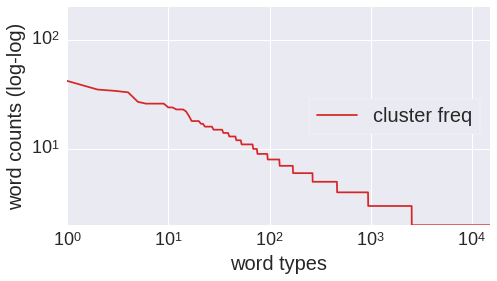

In [50]:
clusters_freq = {cid:len(v) for cid, v in enumerate(clusters_stats['sids'], start=1) \
                 if clusters_stats['purity'][cid-1] >= 0}
plot_word_freq_line(clusters_freq, fig_name="loglog_cluster_id_freq", \
                    label="cluster freq", prefix='c', color=tableau20[6])
# plot_word_freq_line(train_gold_words, fig_name="hehe", prefix='c', color=tableau20[6])
print(len(clusters_freq))

In [51]:
corpus_es_words = []

for fid in align_dict:
    for sid in align_dict[fid]:
         for alist in align_dict[fid][sid]["es"]:
            corpus_es_words.append(alist.word.decode("utf-8").upper())
len(corpus_es_words),len(set(corpus_es_words))
corpus_es_counter = Counter(corpus_es_words)

In [52]:
corpus_word_types = len(corpus_es_counter)
corpus_word_tokens = sum(corpus_es_counter.values())

print("# word types, tokens in entire corpus: {0:d}, {1:d}".format(corpus_word_types, \
                                                                   corpus_word_tokens))

# word types, tokens in entire corpus: 10674, 168195


In [53]:
corpus_en_words = []

for fid in align_dict:
    for sid in align_dict[fid]:
         for alist in align_dict[fid][sid]["en"]:
            corpus_en_words.append(alist.word.decode("utf-8").upper())
len(corpus_en_words),len(set(corpus_en_words))
corpus_en_counter = Counter(corpus_en_words)

In [54]:
corpus_word_types = len(corpus_en_counter)
corpus_word_tokens = sum(corpus_en_counter.values())

print("# word types, tokens in entire corpus: {0:d}, {1:d}".format(corpus_word_types, \
                                                                   corpus_word_tokens))

# word types, tokens in entire corpus: 6723, 159777


In [55]:
clusters_es = {esw: len(clusters_stats['sids'][i]) \
                       for i, esw in enumerate(clusters_stats['most_common']) if esw != ': ('}

clusters_es = {}
for i, esu in enumerate(clusters_stats['most_common']):
    esw = esu.upper()
    if esw != ': (':
        if esw not in clusters_es:
            clusters_es[esw] = [i]
        else:
            clusters_es[esw].append([i])
# print(sum(clusters_es.values()), len(set(clusters_es)))
clusters_es_sorted = sorted([(k,len(v)) for k,v in clusters_es.items()], 
                            reverse=True, key=lambda t:t[1])

In [56]:
print(clusters_es_sorted[:5], clusters_es_sorted[-5:], sep="\n")
clusters_es_cid_corpus_count = [(w,freq, corpus_es_counter[w]) for w, freq in clusters_es_sorted]
out_cols = ["word", "cluster olap", "corpus freq"]
out_rows = []
[out_rows.append(tup) for tup in 
         clusters_es_cid_corpus_count[:10]+clusters_es_cid_corpus_count[-10:]]
clusters_es_cid_corpus_count[:10]
for row in out_rows:
    print(row[0] + " & " + str(row[1]) + " & " + str(row[2]) + " \\\\")
# print "\n".join([" ".join(row) for row in out_rows])
# mini_print(out_cols, out_rows)

[(u'AQU\xcd', 311), (u'BIEN', 259), (u'PUES', 221), (u'VA', 176), (u'SI', 145)]
[(u'BALDES', 1), (u'ABAJO', 1), (u'CREYENDO', 1), (u'CONTESTARTE', 1), (u'PRINCIPAL', 1)]
AQUÍ & 311 & 606 \\
BIEN & 259 & 1183 \\
PUES & 221 & 1236 \\
VA & 176 & 573 \\
SI & 145 & 1045 \\
DÍA & 136 & 280 \\
BUENO & 125 & 1186 \\
ENTONCES & 121 & 775 \\
TIEMPO & 117 & 193 \\
HACER & 113 & 283 \\
CUÍDENSE & 1 & 4 \\
AVERIGÚÉ & 1 & 2 \\
OREJAS & 1 & 3 \\
DARNOS & 1 & 3 \\
DIARIA & 1 & 3 \\
BALDES & 1 & 2 \\
ABAJO & 1 & 18 \\
CREYENDO & 1 & 1 \\
CONTESTARTE & 1 & 3 \\
PRINCIPAL & 1 & 6 \\


In [57]:
# plot_word_freq(corpus_es_counter, fig_name="hehe", prefix='', num=20, color=tableau20[6])

In [58]:
cid_olap = np.array([v for k,v in clusters_es_sorted])
es_count = np.array([corpus_es_counter[k] for k,v in clusters_es_sorted])

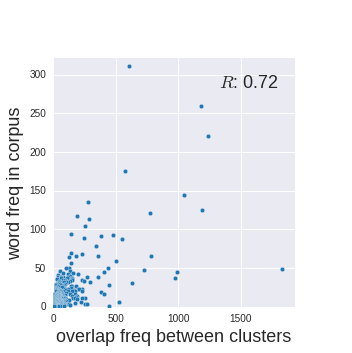

In [59]:
g = sns.JointGrid(x=es_count, y=cid_olap, size=5)
g = g.plot_joint(plt.scatter, color=tableau20[0], s=20, edgecolor="white")
rsquare = lambda a, b: sp.stats.pearsonr(a, b)[0]
g = g.annotate(rsquare, template="{stat}: {val:.2f}", stat="$R$", loc="upper right", fontsize=18)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
plt.gca().set(ylim=(0,np.max(cid_olap)+10))
plt.gca().set(xlim=(0,np.max(es_count)+100))
plt.gca().set_xlabel("overlap freq between clusters", fontsize=18)
plt.gca().set_ylabel("word freq in corpus", fontsize=18)
plt.gcf().tight_layout()
plt.gcf().savefig("cid_corpus_olap.png")

In [60]:
print("Clusters with unique word mappings:")
print(len([1 for i in clusters_es if len(clusters_es[i]) == 1]))
print("Clusters with overlapping word mappings:")
print(sum([len(clusters_es[i]) for i in clusters_es if len(clusters_es[i]) > 1]))
13354 + 121,  1614, len(clusters_es)-1614

Clusters with unique word mappings:
1614
Clusters with overlapping word mappings:
13354


(13475, 1614, 1819)

In [61]:
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [62]:
print(len(clusters_df[clusters_df['same_seg']== True]), len(clusters_df))

267 15089


In [63]:
print(len(clusters_df[clusters_df['cross_seg']== True]), len(clusters_df))

874 15089


In [64]:
print(len(clusters_df[clusters_df['cross_file']== True]), len(clusters_df))

574 15089


In [65]:
cross_seg_cids = {s for s, c in enumerate(clusters_stats['cross_seg']) if c == True}

In [66]:
cross_file_cids = {s for s, c in enumerate(clusters_stats['cross_file']) if c == True}

In [67]:
print(len(set(train_pwords) & set(dev_pwords)))
hmm = {int(i) for i in set(train_pwords) & set(dev_pwords)}

875


### View clusters

In [68]:
view_cols = ['most_common', 'oov', 'purity', 'words', 'depth', 'cross_seg', 'cross_file']

In [69]:
def sid_to_cid_mapping(clusters_stats):
    sid_to_cids = {}
    for cid, sids in enumerate(clusters_stats['sids']):
        for sid in sids:
            if sid not in sid_to_cids:
                sid_to_cids[sid] = set()
            sid_to_cids[sid] |= {cid}
    return sid_to_cids
            

In [70]:
sid_to_cids = sid_to_cid_mapping(clusters_stats)

In [71]:
def get_cids_for_sid(sid, clusters_stats):
    sid_cids = [cid for cid, sids in enumerate(clusters_stats["sids"]) if sid in sids]
    return sid_cids

In [72]:
def find_sids_with_common_pwords(clusters_stats, filter_sids, sid_to_cids):
    check_sids = list(filter_sids)
    sid_overlap = []
    for i in range(len(check_sids)):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(check_sids)) )
        for j in range(i+1, len(check_sids)):
            if check_sids[i] in sid_to_cids and check_sids[j] in sid_to_cids:
                t1 = sid_to_cids[check_sids[i]]
                t2 = sid_to_cids[check_sids[j]]
                if len(t1 & t2) > 0:
                    sid_overlap.append((check_sids[i], check_sids[j], len(t1 & t2), t1&t2))
    return sid_overlap

In [73]:
def find_cids_with_common_sids(clusters_stats, filter_sids):
    cid_overlap = []
    for i in range(len(clusters_stats['sids'])):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(clusters_stats['sids'])) )
        for j in range(i+1, len(clusters_stats['sids'])):
            t1 = set(clusters_stats['sids'][i]) & filter_sids
            t2 = set(clusters_stats['sids'][j]) & filter_sids
            if len(t1 & t2) > 0:
                cid_overlap.append((i, j, len(t1 & t2), t1&t2))
    return cid_overlap

In [74]:
# sid_overlap = find_sids_with_common_pwords(clusters_stats, train_sids, sid_to_cids)

In [75]:
# cid_overlap = find_cids_with_common_sids(clusters_stats, train_sids)

In [76]:
corr = [3, 5, 7]
pred = [5, 10, 15]
gold = [10, 10, 10]
for i in range(3):
    print("%.2f" % (corr[i]/gold[i]), end=" & ")
#     print(corr[i]/pred[i])

0.30 & 0.50 & 0.70 & 

In [77]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(5)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim,in_uttr,x_call,x_uttr
4361,13465,13466,0.999,1,1,1.000000,False,False,True
2869,18715,18716,0.999,1,1,0.250000,False,False,True
12798,12919,12920,0.999,1,1,0.222222,False,False,True
4709,55845,55846,0.999,1,1,0.200000,False,False,True
9457,9885,9886,0.999,1,1,0.142857,False,False,True


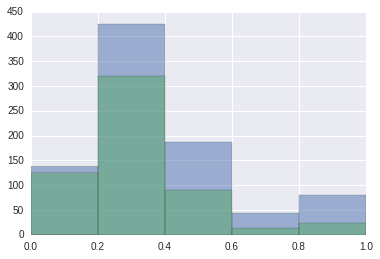

In [78]:
# clusters_df['purity'].hist()
clusters_df.purity[clusters_df.cross_seg == True].hist(alpha=0.5, bins=5)
clusters_df.purity[clusters_df.cross_file == True].hist(alpha=0.5, bins=5)

In [79]:
clusters_stats['avg_purity']

0.33876827491794936

In [80]:
calc_avg_purity(clusters_df)

0.339489235964542

In [81]:
calc_avg_purity(clusters_df[clusters_df.same_seg])

0.59246171967020023

In [82]:
len(clusters_df[(clusters_df.cross_seg ==  True) & (clusters_df.cross_file == True)])

574

In [83]:
# calc_avg_purity(clusters_df[(clusters_df.cross_seg == True) & (clusters_df.cross_file == False)])

In [84]:
calc_avg_purity(clusters_df[clusters_df.cross_file])

0.15341525117455729

In [85]:
calc_avg_purity(clusters_df[clusters_df.is_dev]), calc_avg_purity(clusters_df[clusters_df.is_train])

(0.23679828734538536, 0.31767715775246186)

In [86]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

(574, 15089)

In [87]:
len(clusters_df[clusters_df.is_dev])

1420

In [88]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

546

## Calculate duration in dev, test, and training sets

In [89]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [90]:
dur = {"tot":{}, "ge500ms":{}}

In [91]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [92]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

Completed calculating durations


In [93]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [94]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 9.565(hrs), dur >= 500ms: 8.527(hrs)
71 71


In [95]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

total dur: 1.788(hrs), dur >= 500ms: 1.584(hrs)
13 13


In [96]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, ts_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, ts_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(ts_dur, ts_dur_500ms))
ts_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(ts_files, len(test_dur_500ms_list))

total dur (hrs) 1.351
total dur (hrs) 1.218
total dur: 1.351(hrs), dur >= 500ms: 1.218(hrs)
20 20


In [97]:
print("Total hrs of speech in Callhome: %.2f (hrs), %.2f (hrs>500ms)" % ((t_dur+d_dur+ts_dur), \
                                                    (t_dur_500ms+d_dur_500ms+ts_dur_500ms)))

Total hrs of speech in Callhome: 12.70 (hrs), 11.33 (hrs>500ms)


In [98]:
# Train subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 62, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 62, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

# Dev subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 81, 84)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 81, 84)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 6.841(hrs), dur >= 500ms: 6.104(hrs)
51 51
total dur: 0.509(hrs), dur >= 500ms: 0.446(hrs)
4 4


### EACL plots

In [99]:
def plot_eacl_results(data_array, plotname="", title=""):
    alpha =  np.arange(1,11,1)
    markers = ["o","v","o","v"]
    labels = ['gold:utterance', 'gold:call', 'pseudo:utterance', 'pseudo:call']
    colors = [0, 4, 0, 4]
    linestyles = ['--','--', '-','-']
    
    y_tick_values = [0.05, .2, .4, .6, .8, .9, 1]
    
    fig_size = (8,6)
    fig, ax = plt.subplots(figsize=fig_size)
    for i, arr_data in enumerate(data_array):
        ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
                label=labels[i], markersize=8, linestyle=linestyles[i])
    #ax.yaxis.set_major_locator(MultipleLocator(.05))
    ax.set_xlabel(r'$K$', size=28)
    #ax.set_title(plotname, size=20, y=1.02)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.45),
                      ncol=2, fancybox=True, shadow=True, fontsize=20)
    ax.set_ylabel(title, size=28)
    #ax.set_xticklabels(["{0:0.1f}".format(x) for x in alpha], size=18)
    ax.set_xticklabels(["{0:d}".format(x) for x in alpha], size=24)
    ax.set_xticks(alpha)
    ax.set_yticklabels(["{0:d}%".format(int(y*100.0)) for y in y_tick_values], size=15)
    plt.xticks(rotation=0)
    ax.set_xlim(1,10.5)
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(24)
    
#     for label in ax.get_yticklabels()[::]:
#         label.set_visible(False)
#     ax.get_yticklabels()[-1].set_visible(True)
    
    ax.yaxis.set_ticks(np.array(y_tick_values))
    ax.set_ylim(0,np.max(data_array)+.05)
    
    fig.tight_layout()
    if plotname:
#         fig.savefig(plotname, format='png', dpi=600)
        fig.savefig(plotname.replace("png","pdf"), format='pdf')
    

In [100]:
gold_seg_train_prec = \
    np.array([0.4776, 0.4147, 0.3731, 0.3438, 0.3217, 0.3032, 0.2881, 0.2748, 0.2635, 0.2543])
gold_seg_train_rec = \
    np.array([.4719, 0.6398, 0.7163, 0.7626, 0.7930, 0.8115, 0.8262, 0.8338, 0.8409, 0.8483])
gold_seg_dev_prec = \
    np.array([0.3866, 0.3277, 0.2865, 0.2629, 0.2462, 0.2326, 0.2216, 0.2108, 0.2021, 0.1958])
gold_seg_dev_rec = \
    np.array([.3384, 0.4475, 0.4873, 0.5197, 0.5441, 0.5614, 0.5755, 0.5808, 0.5872, 0.5952])
pseudo_seg_train_prec = \
    np.array([0.4217, 0.3884, 0.3671, 0.3498, 0.3351, 0.3222, 0.3103, 0.2994, 0.2898, 0.2813])
pseudo_seg_train_rec = \
    np.array([.1839, 0.3017, 0.3914, 0.4612, 0.5143, 0.5543, 0.5838, 0.6051, 0.6215, 0.6338])
pseudo_seg_dev_prec = \
    np.array([0.0789, 0.0710, 0.0643, 0.0628, 0.0588, 0.0562, 0.0544, 0.0537, 0.0526, 0.0512])
pseudo_seg_dev_rec = \
    np.array([.0185, 0.0307, 0.0388, 0.0472, 0.0518, 0.0556, 0.0590, 0.0626, 0.0650, 0.0664])
#               0.0182, 0.0305, 0.0385, 0.0470, 0.0519, 0.0562, 0.0594, 0.0628, 0.0657, 0.0681

gold_call_train_prec = \
    np.array([0.4753, 0.4118, 0.3704, 0.3414, 0.3180, 0.2993, 0.2838, 0.2712, 0.2603, 0.2513])
gold_call_train_rec = \
    np.array([.4704, 0.6396, 0.7198, 0.7648, 0.7895, 0.8079, 0.8209, 0.8331, 0.8427, 0.8500])
gold_call_dev_prec = \
    np.array([0.3572, 0.3069, 0.2701, 0.2494, 0.2315, 0.2174, 0.2082, 0.1986, 0.1929, 0.1878])
gold_call_dev_rec = \
    np.array([.2839, 0.3802, 0.4179, 0.4478, 0.4639, 0.4762, 0.4897, 0.4967, 0.5096, 0.5184])
pseudo_call_train_prec = \
    np.array([0.4223, 0.3882, 0.3669, 0.3500, 0.3350, 0.3222, 0.3105, 0.2995, 0.2895, 0.2812])
pseudo_call_train_rec = \
    np.array([.1854, 0.3044, 0.3950, 0.4659, 0.5185, 0.5590, 0.5891, 0.6104, 0.6261, 0.6385])
pseudo_call_dev_prec = \
    np.array([0.0401, 0.0343, 0.0298, 0.0277, 0.0273, 0.0267, 0.0254, 0.0247, 0.0252, 0.0257])
pseudo_call_dev_rec = \
    np.array([.0058, 0.0093, 0.0114, 0.0133, 0.0154, 0.0170, 0.0177, 0.0184, 0.0198, 0.0210])

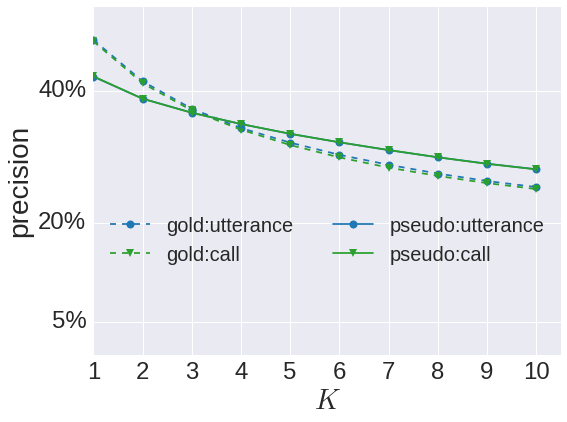

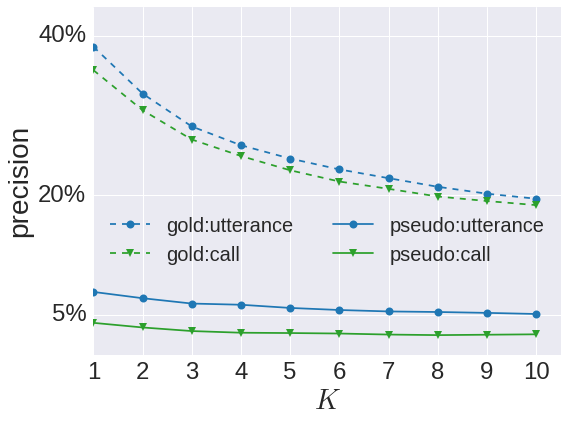

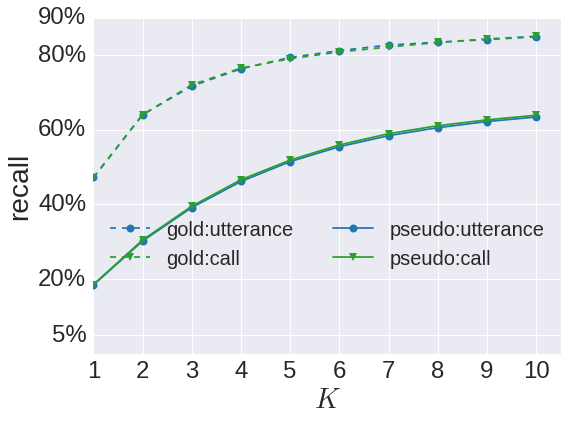

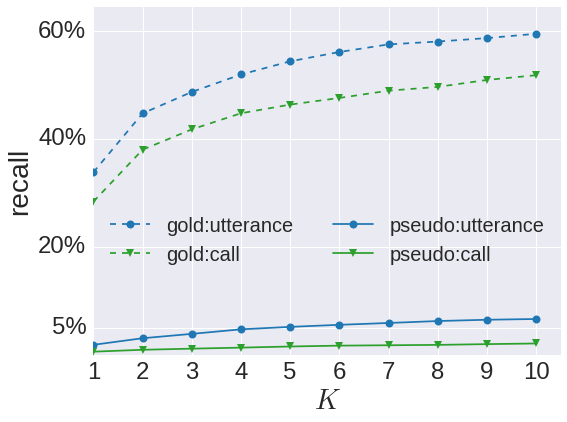

In [101]:
p_train = [gold_seg_train_prec, gold_call_train_prec, pseudo_seg_train_prec, pseudo_call_train_prec]
p_dev = [gold_seg_dev_prec, gold_call_dev_prec, pseudo_seg_dev_prec, pseudo_call_dev_prec]

r_train = [gold_seg_train_rec, gold_call_train_rec, pseudo_seg_train_rec, pseudo_call_train_rec]
r_dev = [gold_seg_dev_rec, gold_call_dev_rec, pseudo_seg_dev_rec, pseudo_call_dev_rec]

titles = ["precision", "precision", "recall", "recall"]
plot_names = ["p_train.png", "p_dev.png", "r_train.png", "r_dev.png"]
all_arrays = [p_train, p_dev, r_train, r_dev]
for i, data_array in enumerate(all_arrays):
    plot_eacl_results(data_array, plotname=plot_names[i], title=titles[i])

In [102]:
p_r_cols = ['metric', 'model', r'$@K=1$', r'$@K=5$']
p_r_rows = []
models = ['gold:seg', 'gold:call', 'pseudo:seg', 'pseudo:call']
for i, p in enumerate(p_dev):
    p_r_rows.append(["prec", models[i]] + map(lambda v: "{0:.2f}\\%".format(v*100.0), p[[0, 4]]))

for i, r in enumerate(r_dev):
    p_r_rows.append(["rec", models[i]] + map(lambda v: "{0:.2f}\\%".format(v*100.0), r[[0, 4]]))

mini_print(p_r_cols, p_r_rows)

metric & model & $@K=1$ & $@K=5$
prec & gold:seg & 38.66\% & 24.62\%
prec & gold:call & 35.72\% & 23.15\%
prec & pseudo:seg & 7.89\% & 5.88\%
prec & pseudo:call & 4.01\% & 2.73\%
rec & gold:seg & 33.84\% & 54.41\%
rec & gold:call & 28.39\% & 46.39\%
rec & pseudo:seg & 1.85\% & 5.18\%
rec & pseudo:call & 0.58\% & 1.54\%
+--------+-------------+---------+---------+
| metric |    model    |  $@K=1$ |  $@K=5$ |
+--------+-------------+---------+---------+
|  prec  |   gold:seg  | 38.66\% | 24.62\% |
|  prec  |  gold:call  | 35.72\% | 23.15\% |
|  prec  |  pseudo:seg |  7.89\% |  5.88\% |
|  prec  | pseudo:call |  4.01\% |  2.73\% |
|  rec   |   gold:seg  | 33.84\% | 54.41\% |
|  rec   |  gold:call  | 28.39\% | 46.39\% |
|  rec   |  pseudo:seg |  1.85\% |  5.18\% |
|  rec   | pseudo:call |  0.58\% |  1.54\% |
+--------+-------------+---------+---------+


In [103]:
p_r_cols = ['metric', 'gold:seg', 'gold:call', 'pseudo:seg', 'pseudo:call']
p_r_rows = []
models = []

p_1_vals = [p_dev[i][0] for i in range(len(p_dev))]
# p_1_vals, map(lambda v: "{0:.2f}\\%".format(v*100.0), p_1_vals)
p_r_rows.append(["prec $@K=1$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), p_1_vals))

r_1_vals = [r_dev[i][0] for i in range(len(r_dev))]
p_r_rows.append(["rec $@K=1$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), r_1_vals))

p_5_vals = [p_dev[i][4] for i in range(len(p_dev))]
p_r_rows.append(["prec $@K=5$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), p_5_vals))

r_5_vals = [r_dev[i][4] for i in range(len(r_dev))]
p_r_rows.append(["rec $@K=5$"] + map(lambda v: "{0:.2f}\\%".format(v*100.0), r_5_vals))


mini_print(p_r_cols, p_r_rows)

metric & gold:seg & gold:call & pseudo:seg & pseudo:call
prec $@K=1$ & 38.66\% & 35.72\% & 7.89\% & 4.01\%
rec $@K=1$ & 33.84\% & 28.39\% & 1.85\% & 0.58\%
prec $@K=5$ & 24.62\% & 23.15\% & 5.88\% & 2.73\%
rec $@K=5$ & 54.41\% & 46.39\% & 5.18\% & 1.54\%
+-------------+----------+-----------+------------+-------------+
|    metric   | gold:seg | gold:call | pseudo:seg | pseudo:call |
+-------------+----------+-----------+------------+-------------+
| prec $@K=1$ | 38.66\%  |  35.72\%  |   7.89\%   |    4.01\%   |
|  rec $@K=1$ | 33.84\%  |  28.39\%  |   1.85\%   |    0.58\%   |
| prec $@K=5$ | 24.62\%  |  23.15\%  |   5.88\%   |    2.73\%   |
|  rec $@K=5$ | 54.41\%  |  46.39\%  |   5.18\%   |    1.54\%   |
+-------------+----------+-----------+------------+-------------+


In [104]:
[r_dev[i][0] for i in range(len(r_dev))]

[0.33839999999999998,
 0.28389999999999999,
 0.018499999999999999,
 0.0057999999999999996]

## Review translations

In [105]:
K = 2
PRED_NUM = 10
MATCH_NUM = 10

In [106]:
import heapq
import textwrap

def get_top_segs(eval_dict, num=10, reverse=False):
    eval_list = [(s, eval_dict[s]['cp']/eval_dict[s]['t']) for s in eval_dict if "." in s \
                if eval_dict[s]['tp'] > 0 and eval_dict[s]['t'] >= 3]
    
    return sorted(eval_list, reverse= not(reverse), key=lambda t:t[1])[:num]
#     if reverse:
#         return heapq.nsmallest(num, eval_list, key=lambda t:t[1])
#     else:
#         return heapq.nlargest(num, eval_list, key=lambda t:t[1])
    

In [133]:
# %%timeit -r1 -n1
best_preds = get_top_segs(mt_pseudo_eval_dict['dev'][K], num=PRED_NUM)
best_oracle_preds = get_top_segs(mt_gold_eval_dict['dev'][K], num=PRED_NUM)
bad_preds = get_top_segs(mt_pseudo_eval_dict['dev'][K], reverse=True, num=PRED_NUM)

In [163]:
def display_oracle_preds(pred_list, align_dict, pred_dict):
    out_cols = ["gold", "oracle pred"]
    out_rows = []
    for i, pred in enumerate(pred_list):
        sid = pred[0]
#         ref_es_words = get_en_words(align_dict, sid, "es")
#         ref_es_cnt_words = get_en_words(align_dict, sid, "es_cnt")
        
        ref_en_words = get_en_words(align_dict, sid, "en")
        ref_en_cnt_words = get_en_words(align_dict, sid, "en_cnt")
        
        p_en_words = pred_dict[sid]
        p_en_words = [(r"%s" % w) if \
                      w in nltk.corpus.stopwords.words("english") else w  for w in p_en_words]
#         c_words = set(ref_en_words) & set(p_en_words)
        
#         ref_es_words = [(r"\uline{%s}" % w) if w in c_words else w for w in ref_en_words]
#         ref_es_words = [(r"\noindent{{\color{lightgray} %s}}" % w) if w not in ref_es_cnt_words else w \
#                         for w in ref_es_words]
        ref_en_words = [(r"%s" % w) if w not in ref_en_cnt_words and "uline" not in w else w \
                        for w in ref_en_words]
        
#         p_en_words = [(r"\uline{%s}" % w) if w in c_words else w for w in p_en_words]
#         out_rows.append([str(i+1), " ".join(ref_es_words).lower(), " ".join(ref_en_words).lower(), 
#                          " ".join(p_en_words).lower() + " \\\\"])
        out_rows.append([" ".join(ref_en_words).lower(), " ".join(p_en_words).lower() + " \\\\"])
#         print(ref_en_cnt_words)
    mini_print(out_cols, out_rows)

In [164]:
def display_preds(pred_list, align_dict, pred_dict):
    out_cols = ["gold trans", "gold pred", "model pred"]
    out_rows = []
    for i, pred in enumerate(pred_list):
        sid = pred[0]
        ref_es_words = get_en_words(align_dict, sid, "es")
        ref_es_cnt_words = get_en_words(align_dict, sid, "es_cnt")
        
        ref_en_words = get_en_words(align_dict, sid, "en")
        ref_en_cnt_words = get_en_words(align_dict, sid, "en_cnt")
        
        p_en_words = pred_dict[sid]
        c_words = set(ref_en_words) & set(p_en_words)
        
#         ref_es_words = [(r"\uline{%s}" % w) if w in c_words else w for w in ref_en_words]
        ref_es_words = [(r"\noindent{{\color{lightgray} %s}}" % w) if w not in ref_es_cnt_words else w \
                        for w in ref_es_words]
        
        ref_en_words = [(r"\uline{%s}" % w) if w in c_words else w for w in ref_en_words]
        ref_en_words = [(r"\noindent{{\color{lightgray} %s}}" % w) if w not in ref_en_cnt_words and "uline" not in w else w \
                        for w in ref_en_words]
        
        p_en_words = [(r"\uline{%s}" % w) if w in c_words else w for w in p_en_words]
#         out_rows.append([str(i+1), " ".join(ref_es_words).lower(), " ".join(ref_en_words).lower(), 
#                          " ".join(p_en_words).lower() + " \\\\"])
        out_rows.append([" ".join(ref_es_words).lower(), " ".join(ref_en_words).lower(), 
                         " ".join(p_en_words).lower() + " \\\\"])
#         print(ref_en_cnt_words)
    mini_print(out_cols, out_rows)

In [165]:
display_preds(best_preds, align_dict, mt_pseudo_pred_dict[K])

gold trans & gold pred & model pred
cómo anda \noindent{{\color{lightgray} el}} plan escolar & \noindent{{\color{lightgray} how}} \noindent{{\color{lightgray} is}} \noindent{{\color{lightgray} the}} \uline{school} plan \uline{going} & \uline{school} \uline{going} \\
dile \noindent{{\color{lightgray} que}} \noindent{{\color{lightgray} le}} mando saludos & tell \noindent{{\color{lightgray} him}} \noindent{{\color{lightgray} that}} \noindent{{\color{lightgray} i}} \uline{say} \uline{hi} & \uline{say} \uline{hi} \\
\noindent{{\color{lightgray} sí}} \noindent{{\color{lightgray} con}} dos dientes menos & \uline{yeah} \noindent{{\color{lightgray} with}} two \uline{teeth} less & denture \uline{yeah} \uline{teeth} \\
\noindent{{\color{lightgray} o}} dejando \noindent{{\color{lightgray} o}} dejando dos días & \noindent{{\color{lightgray} or}} giving \noindent{{\color{lightgray} or}} giving \uline{two} \uline{days} & \uline{days} \uline{two} \\
\noindent{{\color{lightgray} no}} \noindent{{\color{

In [166]:
"said" not in nltk.corpus.stopwords.words("english")

True

In [169]:
display_oracle_preds(best_preds, align_dict, mt_gold_pred_dict[K])

gold & oracle pred
how is the school plan going & things ´ whoa mean plan school \\
tell him that i say hi & tell send best says \\
yeah with two teeth less & two teeth less least \\
or giving or giving two days & improves apart improves apart two days \\
no not from here no no well you know that paris is complicated it not like here & couldn back well know paris complicated inhabitants feels \\
eighteen zero one & eighteenth eighteen zero \\
ah yeah okay twenty third of november no & oh ah okay another three fourth november \\
it was very very tough and only god can give the strength that need that that we need to move forward because really & image agencies alone minute god cannot sentence give fortitude really us really us affairs keep ahead forward really yes felt yes \\
well here in the in the in the chama chama have to call the central university of venezuela and ask a modem & good well inhabitants feels co girl chama call university central venezuela give modem \\
yeah and then 

/disk/scratch/s1444673/zero/miniconda2/envs/zrt/lib/python2.7/site-packages/ipykernel/__main__.py:13: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [110]:
"school" in nltk.corpus.stopwords.words('english')

False

In [111]:
display_preds(bad_preds, align_dict, mt_pseudo_pred_dict[K])

gold trans & gold pred & model pred
\noindent{{\color{lightgray} pero}} \noindent{{\color{lightgray} esa}} \noindent{{\color{lightgray} es}} \noindent{{\color{lightgray} mi}} planificación inicial \noindent{{\color{lightgray} no}} sé si irá \noindent{{\color{lightgray} a}} ocurrir así voy \noindent{{\color{lightgray} a}} hacer \noindent{{\color{lightgray} todo}} \noindent{{\color{lightgray} lo}} posible \noindent{{\color{lightgray} para}} \noindent{{\color{lightgray} que}} ocurra \noindent{{\color{lightgray} y}} bueno pues \noindent{{\color{lightgray} ya}} veremos \noindent{{\color{lightgray} qué}} \noindent{{\color{lightgray} es}} \noindent{{\color{lightgray} lo}} \noindent{{\color{lightgray} que}} pasa \noindent{{\color{lightgray} no}} \noindent{{\color{lightgray} es}} \noindent{{\color{lightgray} mucho}} tiempo & \noindent{{\color{lightgray} but}} \noindent{{\color{lightgray} that}} tentative tentative plan \noindent{{\color{lightgray} don}} know \noindent{{\color{lightgray} if}} \n

In [112]:
def get_top_matched_words(align_dict, pred_list, sid_list, num=10, reverse=False):
    
    dev_en_gold = []
    dev_en_remain = []
    
    for i, sid in enumerate([s for s in pred_list if s in sid_list]):
        gold_seg_en = get_en_words(align_dict, sid, "en_cnt")
        dev_en_gold.extend(gold_seg_en)
        for pred_word in pred_list[sid]:
            if pred_word in gold_seg_en:
                gold_seg_en.remove(pred_word)
        dev_en_remain.extend(gold_seg_en)

    dev_en_gold_counter = Counter(dev_en_gold)
    dev_en_remain_counter = Counter(dev_en_remain)
    
    return dev_en_gold_counter, dev_en_remain_counter


In [113]:
# %%timeit -r1 -n1
dev_en_gold_counter, dev_en_remain_counter = \
            get_top_matched_words(align_dict, pred_list=mt_pseudo_pred_dict[K], \
                                  sid_list=dev_sids, num=PRED_NUM)

No content word found in 088.141 segment
No content word found in 086.150 segment
No content word found in 117.058 segment
No content word found in 085.015 segment
No content word found in 085.253 segment
No content word found in 083.018 segment
No content word found in 100.076 segment
No content word found in 093.070 segment
No content word found in 093.071 segment
No content word found in 086.152 segment
No content word found in 077.027 segment
No content word found in 113.163 segment
No content word found in 111.184 segment
No content word found in 065.202 segment
No content word found in 092.092 segment
No content word found in 067.056 segment
No content word found in 094.023 segment
No content word found in 111.106 segment
No content word found in 115.021 segment
No content word found in 090.149 segment
No content word found in 113.068 segment


In [132]:
len(train_sids), len(dev_sids), 214/8094 * 100

(8094, 872, 2.6439337781072396)

In [114]:
tot = sum(dev_en_gold_counter.values())
rem = sum(dev_en_remain_counter.values())
rec = (tot-rem) / tot * 100
print(rec)

3.05454545455


In [115]:
dev_en_match_counter = (dev_en_gold_counter-dev_en_remain_counter)

In [116]:
dev_en_match_dict = {w:(dev_en_match_counter[w],dev_en_gold_counter[w]) for w in dev_en_gold_counter}

In [117]:
sorted_dev_en_match = sorted([(w.lower(),v[0],v[1]) for w,v in dev_en_match_dict.items()], \
                             reverse=True, key=lambda t:t[1]/t[2])

In [118]:
mini_print(["word", "match", "tot"], \
           sorted_dev_en_match[:MATCH_NUM])

word & match & tot
bottles & 1 & 1
chinese & 1 & 1
water & 1 & 1
argentina & 1 & 1
truth & 1 & 1
monterrey & 1 & 1
days & 1 & 1
honorary & 1 & 1
movement & 1 & 1
strength & 1 & 1
+-----------+-------+-----+
|    word   | match | tot |
+-----------+-------+-----+
|  bottles  |   1   |  1  |
|  chinese  |   1   |  1  |
|   water   |   1   |  1  |
| argentina |   1   |  1  |
|   truth   |   1   |  1  |
| monterrey |   1   |  1  |
|    days   |   1   |  1  |
|  honorary |   1   |  1  |
|  movement |   1   |  1  |
|  strength |   1   |  1  |
+-----------+-------+-----+


In [119]:
# mini_print(["word", "match", "tot"], \
#            sorted_dev_en_match[-MATCH_NUM:])

In [120]:
sorted_dev_en_match = sorted([(w.lower(),v[0],v[1]) for w,v in dev_en_match_dict.items() if v[0] > 0], \
                             reverse=True, key=lambda t:t[2])

In [121]:
mini_print(["word", "match", "tot"], \
           sorted_dev_en_match[:MATCH_NUM])

word & match & tot
yes & 7 & 175
well & 5 & 85
ah & 2 & 69
see & 1 & 64
yeah & 1 & 62
oh & 1 & 59
know & 6 & 53
like & 2 & 44
right & 1 & 42
going & 2 & 41
+-------+-------+-----+
|  word | match | tot |
+-------+-------+-----+
|  yes  |   7   | 175 |
|  well |   5   |  85 |
|   ah  |   2   |  69 |
|  see  |   1   |  64 |
|  yeah |   1   |  62 |
|   oh  |   1   |  59 |
|  know |   6   |  53 |
|  like |   2   |  44 |
| right |   1   |  42 |
| going |   2   |  41 |
+-------+-------+-----+


In [122]:
sum(dev_en_match_counter.values())

126

In [123]:
" ".join([w.lower() for w in dev_en_match_counter])

'funny bottles knowledge people explain back truth stores strength chinese say movement week apartment yeah brazilian go party school aha look oh money water yes yet twelve code says palace susan four going november hundred find happy modem exactly sick around geraldine five said days mom mexico sure know works work think see weather ask hasn knoxville number need argentina come like thirty twenty yesterday \xc2\xb4 matter hi tell monday boston honorary two understand lot university well one policy called told monterrey good okay ah study thing computer teeth tomorrow right vice make salta call buckets bought'

In [124]:
" ".join([w.lower() for w in \
          set(dev_en_gold_counter.keys())-set(dev_en_match_counter.keys())][:217])

'ago grown life everyone buddy spite text age later dramatic environment courses strange thanks fall growing killing dedicated furrow among sister printer last ringing tells hmm things tinso platelets concrete thermal much honestly stays aunt cases dress santi maria saying six raining grabbing kisses fix foam anyway least hand kiko caress pesos sweet phone weird bye venezuela stitches beautiful catholic staying gets specially visiting may house review accent telephone comfortable person near traveling uncle vacations telling law structures realize happiness man great used destiny psychiatrist movie expense friday ximena tests fucked defender guy invented eh arrives doctor painted company huh denver manuelita talking camera arrived something pays starting wow western sending lazy necessarily paris thousand responsible dude else ridden put woman baby christian agree cool envelope try tumour ma lies mm saved uhm lessen gonna public traffic listening pictures degrees pulled ina swim august

In [125]:
[w.word for w in align_dict['001']['001.001']['es_cnt']]

['MECHITA', 'MANDADO', 'QUI\xc3\xa9N', 'POCHO']

In [183]:
es_w_set = []
en_w_set = []
for seg in train_sids:
    es_w_set.extend(gold_feats_dict[seg])
    en_w_set.extend(get_en_words(align_dict, seg, 'en_cnt'))
    

No content word found in 065.128 segment
No content word found in 110.031 segment
No content word found in 071.070 segment
No content word found in 084.094 segment
No content word found in 085.088 segment
No content word found in 063.171 segment
No content word found in 115.149 segment
No content word found in 094.174 segment
No content word found in 097.009 segment
No content word found in 105.021 segment
No content word found in 105.020 segment
No content word found in 063.159 segment
No content word found in 087.145 segment
No content word found in 073.117 segment
No content word found in 082.039 segment
No content word found in 107.124 segment
No content word found in 087.083 segment
No content word found in 114.036 segment
No content word found in 086.137 segment
No content word found in 070.170 segment
No content word found in 077.111 segment
No content word found in 077.112 segment
No content word found in 087.163 segment
No content word found in 119.140 segment
No content word 

In [184]:
print(len(es_w_set), len(set(es_w_set)))
print(len(en_w_set), len(set(en_w_set)))
    

38042 6638
38499 4425


In [181]:
38042 6638
38057 4366

SyntaxError: invalid syntax (<ipython-input-181-3797b1ae3a97>, line 1)

In [176]:
A = []
A.extend(gold_feats_dict['111.111'])

In [177]:
A

['SALUDARLA', 'LLAM\xc3\xb3', 'AH']

In [16]:
align_dict["081"]["081.002"]["es"]

[Align(word='OKEY', start=12, end=56),
 Align(word='QU\xc3\xa9DENSE', start=136, end=159),
 Align(word='EL', start=159, end=165),
 Align(word='EL', start=165, end=171),
 Align(word='MIAMI', start=171, end=202),
 Align(word='DADE', start=202, end=218),
 Align(word='YO', start=266, end=278),
 Align(word='PUEDE', start=278, end=296),
 Align(word='QUE', start=296, end=307),
 Align(word='BAJE', start=307, end=332),
 Align(word='ENTONCES', start=332, end=369)]